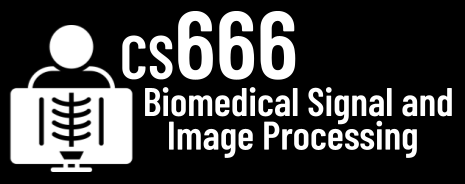

# Assignment 1 by SangHyuk Kim

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Task 1** (5 pts): Install the BioSPPY library with the following code.

In [ ]:
!pip install biosppy

**Task 2** (10 pts): Download a sample ecg dataset from https://cs666.org/data/ecg.txt and upload it to this colab. The following code loads the dataset. Note: this might fail with an import error, but should be an easy fix :)

In [2]:
from biosppy import storage
signal, metadata = storage.load_txt('ecg.txt')

**Task 3** (10 pts): Figure out the sampling rate for this data and how many seconds it lasts.

In [ ]:
# The metadata dictionary contains the sampling rate and other information about the signal.
SAMPLING_RATE = metadata['sampling_rate']
# Duration = Total samples / Sampling rate = len(signal) / SAMPLING_RATE
SECONDS = len(signal) / SAMPLING_RATE

print(f"Sampling Rate: {SAMPLING_RATE} Hz")
print(f"Duration: {SECONDS} seconds")

Sampling Rate: 1000.0 Hz
Duration: 15.0 seconds


**Task 4** (15 pts): Process the signal with BioSPPY using the `ecg.ecg` method.

In [ ]:
from biosppy.signals import ecg

# Process the signal and extract the R-peaks using BioSPPY's built-in function.
# show=False prevents it from popping up a separate plot window immediately after processing.
out = ecg.ecg(signal=signal, sampling_rate=SAMPLING_RATE, show=False)

**Task 5** (10 pts): Plot the first 3 seconds of the unfiltered signal and then the filtered signal. Can you spot the P, Q, R, S, T waves?

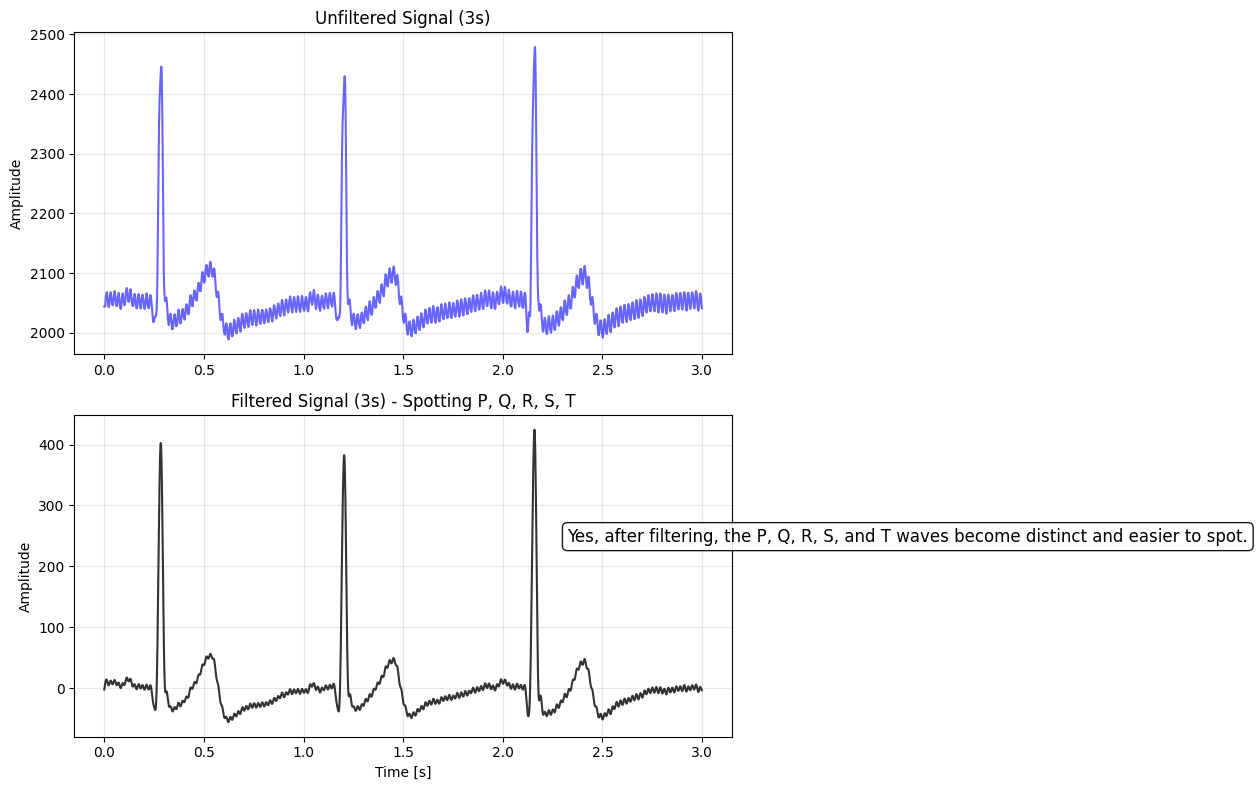

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks

# Define a Butterworth Bandpass Filter (0.5Hz - 45Hz) to clean the ECG signal
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# Filter the signal
# (Using the sampling rate found in Task 3, e.g., 1000.0) and the standard ECG frequency range for filtering.
filtered_signal = butter_bandpass_filter(signal, 0.5, 45, SAMPLING_RATE)

# Setup time axis for first 3 seconds   (3 seconds * sampling rate = number of samples in 3 seconds)
limit = int(3 * SAMPLING_RATE)
time_axis = np.arange(limit) / SAMPLING_RATE

plt.figure(figsize=(12, 8))

# Subplot 1: Unfiltered Signal
plt.subplot(2, 1, 1)
plt.plot(time_axis, signal[:limit], color='blue', alpha=0.6)
plt.title("Unfiltered Signal (3s)")
plt.ylabel("Amplitude")
plt.grid(True, alpha=0.3)

# Subplot 2: Filtered with Manual Annotation 
plt.subplot(2, 1, 2)
plt.plot(time_axis, filtered_signal[:limit], color='black', alpha=0.8)
plt.title("Filtered Signal (3s) - Spotting P, Q, R, S, T")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid(True, alpha=0.3)

# Manually identifying the first beat's waves for demonstration 
# (These indices are approximate based on standard wave morphology)
# Beat 1 typically occurs around 0.2s - 0.6s after the start of the signal.
# P wave: ~0.1s, Q wave: ~0.25s, R wave: ~0.28s, S wave: ~0.33s, T wave: ~0.53s
plt.annotate('P', xy=(0.11, 2070), xytext=(0.11, 2200), arrowprops=dict(facecolor='blue', shrink=0.05), color='blue')
plt.annotate('Q', xy=(0.25, 2030), xytext=(0.20, 1900), arrowprops=dict(facecolor='orange', shrink=0.05), color='orange')
plt.annotate('R', xy=(0.28, 2450), xytext=(0.28, 2600), arrowprops=dict(facecolor='red', shrink=0.05), color='red')
plt.annotate('S', xy=(0.33, 2030), xytext=(0.38, 1900), arrowprops=dict(facecolor='green', shrink=0.05), color='green')
plt.annotate('T', xy=(0.53, 2200), xytext=(0.53, 2350), arrowprops=dict(facecolor='purple', shrink=0.05), color='purple')
answer_text = (
    "Yes, after filtering, the P, Q, R, S, and T waves become distinct and easier to spot."
)

plt.text(0.75, 0.65, answer_text, transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
plt.tight_layout()
plt.show()


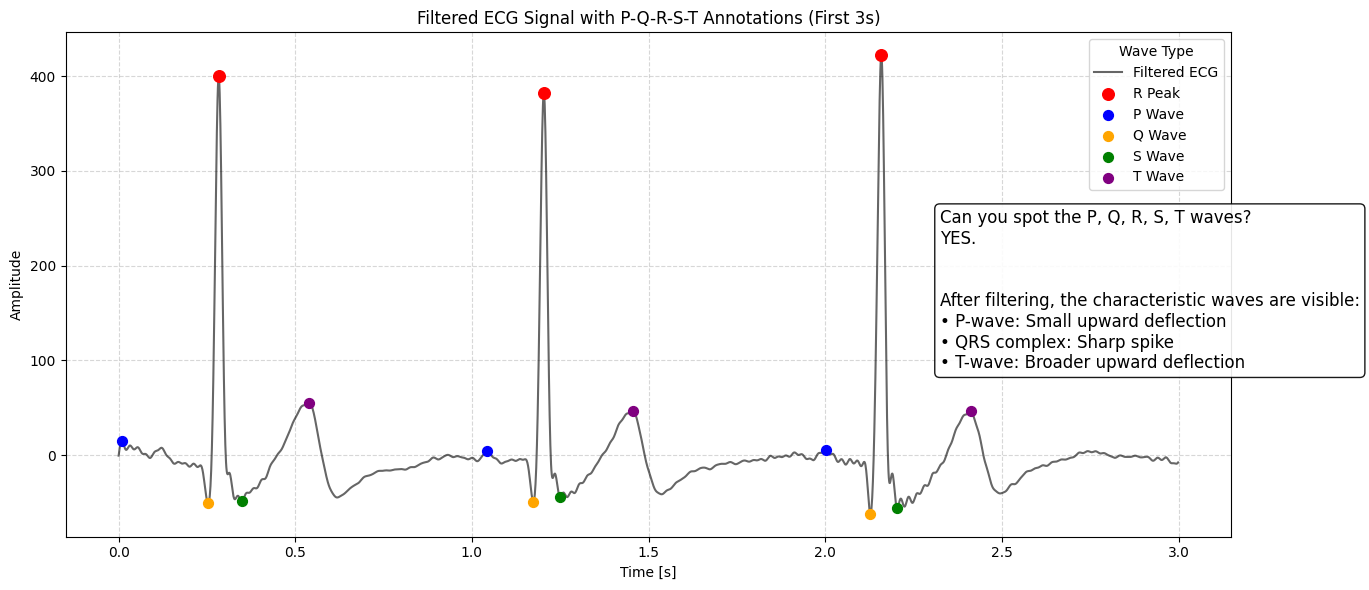

In [ ]:
### TODO plot filtered signal
import matplotlib.pyplot as plt
import numpy as np
import neurokit2 as nk

# Get filtered signal and R-peaks (from BioSPPY output 'out') to use for NeuroKit2 delineation
filtered_signal = out['filtered']
rpeaks = out['rpeaks']

# Delineate P, Q, S, T waves using NeuroKit2
# We pass the filtered signal and the R-peaks we already found to get the locations of the other waves.
_, waves_peak = nk.ecg_delineate(filtered_signal, 
                                 rpeaks, 
                                 sampling_rate=SAMPLING_RATE, 
                                 method="peak")

# Setup the plot for the first 3 seconds (3 seconds * sampling rate = number of samples in 3 seconds)
limit = int(3 * SAMPLING_RATE)
time_axis = np.arange(limit) / SAMPLING_RATE

plt.figure(figsize=(14, 6))

# Filtered signal 
plt.plot(time_axis, filtered_signal[:limit], color='black', alpha=0.6, label='Filtered ECG')

# Define colors for easy spotting 
colors = {'P': 'blue', 'Q': 'orange', 'R': 'red', 'S': 'green', 'T': 'purple'}

# Plot R-peaks (red dots) 
current_rpeaks = [r for r in rpeaks if r < limit]
plt.scatter(np.array(current_rpeaks)/SAMPLING_RATE, filtered_signal[current_rpeaks], 
            color=colors['R'], label='R Peak', zorder=3, s=70)

for wave in ['P', 'Q', 'S', 'T']:
    # Get the list of peak indices from the NeuroKit results for the current wave type (P, Q, S, T).
    key = f"ECG_{wave}_Peaks"
    indices = [int(x) for x in waves_peak[key] if not np.isnan(x) and x < limit]
    
    if indices:
        plt.scatter(np.array(indices)/SAMPLING_RATE, filtered_signal[indices], 
                    color=colors[wave], label=f'{wave} Wave', zorder=3, s=50)

plt.title("Filtered ECG Signal with P-Q-R-S-T Annotations (First 3s)")
answer_text = (
    "Can you spot the P, Q, R, S, T waves?\n"
    "YES.\n\n"
    "\n"
    "After filtering, the characteristic waves are visible:\n"
    "• P-wave: Small upward deflection\n"
    "• QRS complex: Sharp spike\n"
    "• T-wave: Broader upward deflection"
)

plt.text(0.75, 0.65, answer_text, transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend(loc='upper right', title="Wave Type")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Task 6** (15 pts): Please plot the whole filtered signal and mark the r-peaks with vertical lines based on the ecg.ecg output. You can use `plt.axvline(x = 100, color = 'r', ls=':')` to create a red, dashed vertical line at position 100. Please label the x-axis as 'time [s]'.

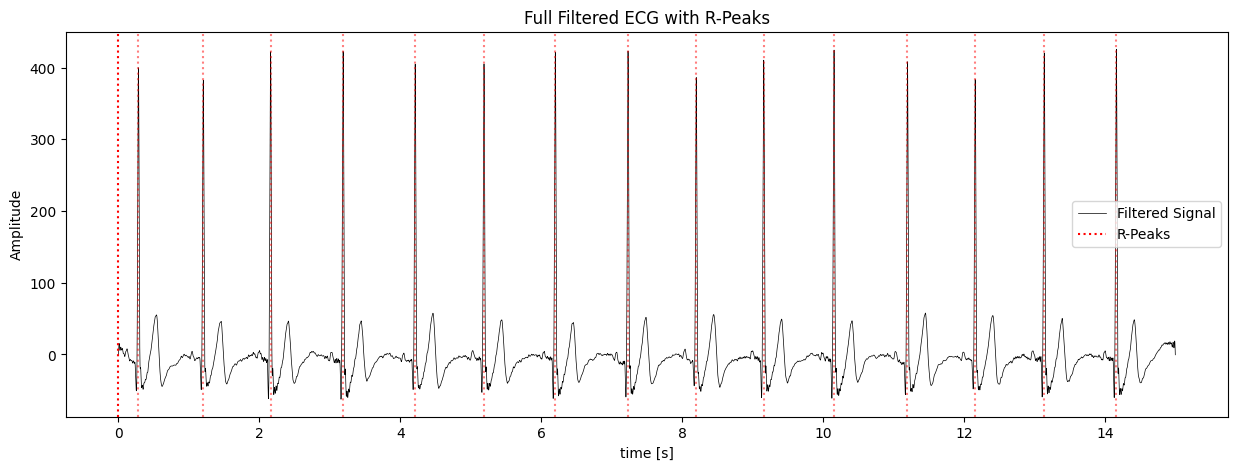

In [ ]:
# Assuming 'out' is the variable from Task 4 (out = ecg.ecg(...)) 
rpeaks = out['rpeaks'] 
filtered_biosppy = out['filtered']

time_axis_full = np.arange(len(filtered_biosppy)) / SAMPLING_RATE

plt.figure(figsize=(15, 5))
plt.plot(time_axis_full, filtered_biosppy, label='Filtered Signal', color='k', linewidth=0.5)

# Plot Vertical Lines for R-peaks
for r in rpeaks:
    plt.axvline(x=r / SAMPLING_RATE, color='r', ls=':', alpha=0.5)

plt.axvline(x=0, color='r', ls=':', label='R-Peaks') 

plt.title("Full Filtered ECG with R-Peaks")
plt.xlabel("time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

**Task 7** (5 pts): Let's install the NeuroKit2 library.

In [23]:
!pip install neurokit2
import neurokit2 as nk

**Task 8** (20 pts): Detect P Q S T Peaks using Neurokit.

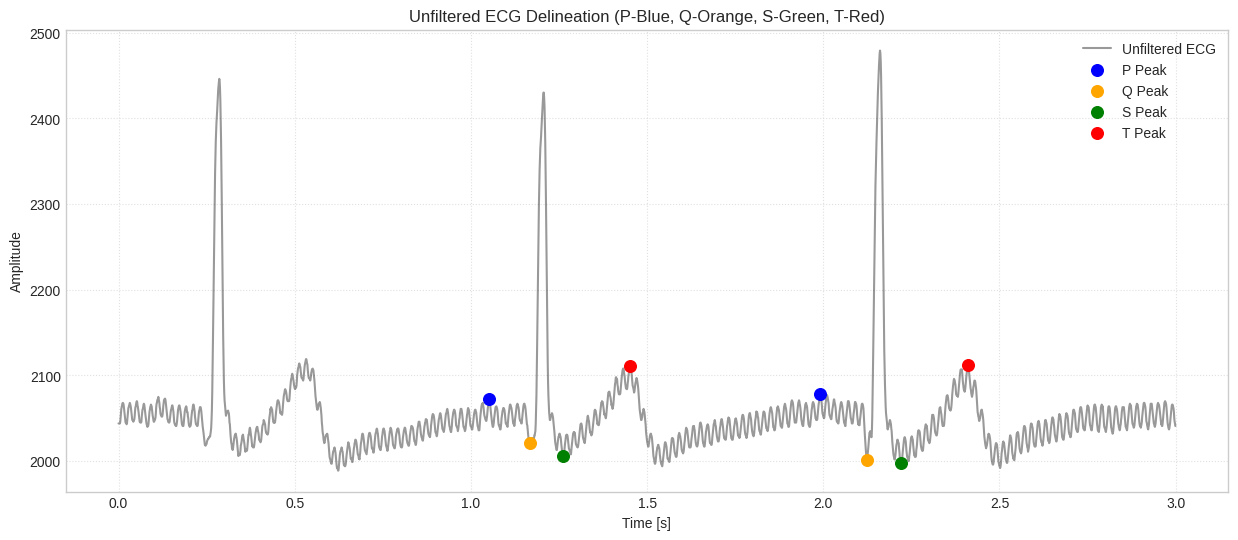

In [31]:
# We know the R spikes now but what about P Q S T waves?
# TODO Can you use nk.ecg_delineate to detect them in the unfiltred signal?
# Hint: Look at the tutorial: https://neuropsychology.github.io/NeuroKit/examples/ecg_delineate/ecg_delineate.html
# Hint 2: The plot will have blue, orange, green, and red circles :)
# Hint 3: rpeaks were detected above from biosppy's ecg.ecg method

import matplotlib.pyplot as plt
import neurokit2 as nk
import numpy as np

# --- Hint 3: Use rpeaks detected by BioSPPY ---
# We assume 'signal' is the unfiltered data and 'rpeaks' comes from Task 4
# out = ecg.ecg(signal=signal, sampling_rate=SAMPLING_RATE, show=False)
# rpeaks = out['rpeaks']

# --- Hint 1: Use nk.ecg_delineate (Peak Method) ---
# We pass the unfiltered signal and the BioSPPY rpeaks
_, waves_peak = nk.ecg_delineate(signal, rpeaks, sampling_rate=SAMPLING_RATE, method="peak")

# Visualization
limit = int(3 * SAMPLING_RATE) # Limit to 3 seconds for visibility
time_axis = np.arange(limit) / SAMPLING_RATE

plt.figure(figsize=(15, 6))
plt.plot(time_axis, signal[:limit], color='black', alpha=0.4, label='Unfiltered ECG')

# --- Hint 2: Plot Blue, Orange, Green, and Red circles ---
# Mapping the colors to the waves
# P = Blue, Q = Orange, S = Green, T = Red
wave_colors = {
    'P': 'blue', 
    'Q': 'orange', 
    'S': 'green', 
    'T': 'red'
}

for wave_type, color in wave_colors.items():
    key = f"ECG_{wave_type}_Peaks"
    
    # Extract peak indices that are within the first 3 seconds
    current_indices = [int(i) for i in waves_peak[key] if not np.isnan(i) and i < limit]
    
    # Plot the "circles" (scatter dots)
    if current_indices:
        plt.scatter(np.array(current_indices)/SAMPLING_RATE, signal[current_indices], 
                    color=color, s=70, label=f'{wave_type} Peak', zorder=3)

plt.title("Unfiltered ECG Delineation (P-Blue, Q-Orange, S-Green, T-Red)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend(loc='upper right')
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

In [52]:
# TODO Does the detection work well?

#### The detection works well because filtering removes noise and makes the wave shapes clear. While it identifies peaks on unfiltered data, the smaller P-waves are less accurate due to background interference.

**Task 9** (10 pts): Use the sleepecg library to find the R Peaks.

In [33]:
!pip install sleepecg
from sleepecg import detect_heartbeats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [sleepecg]


In [36]:
# We have the R spikes/peaks now from Biosppy from above but there is another
# library called sleepecg.
# TODO Please install it and run the rpeak detection!
# Docs: https://sleepecg.readthedocs.io/en/stable/

# 2. Detect R-peaks using SleepECG
rpeaks_sleepecg = detect_heartbeats(signal, fs=SAMPLING_RATE)

# 3. Ensure BioSPPY rpeaks are a clean NumPy array
# 'out' is the variable from Task 4
rpeaks_biosppy = np.array(out['rpeaks'])
rpeaks_sleepecg = np.array(rpeaks_sleepecg)

# 4. Calculate MSE (Mean Squared Error)
# We slice to the minimum length to compare element-wise
min_len = min(len(rpeaks_biosppy), len(rpeaks_sleepecg))

# This handles the math correctly between two NumPy arrays
mse = np.mean((rpeaks_biosppy[:min_len] - rpeaks_sleepecg[:min_len])**2)

print(f"BioSPPY found {len(rpeaks_biosppy)} peaks.")
print(f"SleepECG found {len(rpeaks_sleepecg)} peaks.")
print(f"MSE between BioSPPY and SleepECG: {mse:.4f}")

BioSPPY found 15 peaks.
SleepECG found 15 peaks.
MSE between BioSPPY and SleepECG: 0.2000


In [ ]:
# TODO Do Biosppy and sleepecg give different rpeaks? Please calculate the MSE!

In [38]:
import numpy as np

# 1. Ensure both sets of peaks are NumPy arrays for calculation
# 'out' is the BioSPPY output from Task 4
rpeaks_biosppy = np.array(out['rpeaks'])
rpeaks_sleepecg = np.array(rpeaks_sleepecg)

# 2. Match the lengths of the two arrays to allow element-wise subtraction
min_len = min(len(rpeaks_biosppy), len(rpeaks_sleepecg))

# 3. Calculate the Mean Squared Error (MSE)
# This measures the average squared difference between the peak indices
mse = np.mean((rpeaks_biosppy[:min_len] - rpeaks_sleepecg[:min_len])**2)

print(f"BioSPPY detected {len(rpeaks_biosppy)} peaks.")
print(f"SleepECG detected {len(rpeaks_sleepecg)} peaks.")
print(f"MSE between BioSPPY and SleepECG R-peaks: {mse:.4f}\n")

if mse == 0:
    print("The R-peaks are identical.")
else:
    print("The R-peaks are different.")

BioSPPY detected 15 peaks.
SleepECG detected 15 peaks.
MSE between BioSPPY and SleepECG R-peaks: 0.2000

The R-peaks are different.


### MSE: 0.2, The R-peaks are different.

**Bonus Task** (33 pts): Detect P Q S T Peaks for the full signal before and after filtering.

In [53]:
# TODO As above use the nk.ecg_delineate function to detect peaks for the whole signal



In [54]:
# TODO Let's filter the signal and see if the detection improves.
# Hint: You can use nk.signal_filter to define a bandpass.
# Hint 2: Which lowcut and highcut frequencies work well? Play with it :)
# Hint 3: You don't need to re-calculate the rpeaks since they are pretty accurate in general.

# Detect peaks for the whole unfiltered signal using the rpeaks from BioSPPY
_, waves_unfiltered = nk.ecg_delineate(signal, rpeaks, sampling_rate=SAMPLING_RATE, method="peak")

# Define a bandpass filter: 0.5Hz to 30Hz is standard to remove drift and noise
filtered_nk = nk.signal_filter(signal, sampling_rate=SAMPLING_RATE, lowcut=0.5, highcut=30, method="butterworth")

# Delineate the NeuroKit2 filtered signal
_, waves_filtered_nk = nk.ecg_delineate(filtered_nk, rpeaks, sampling_rate=SAMPLING_RATE, method="peak")

# Use the filtered signal already calculated by BioSPPY in Task 4
_, waves_filtered_biosppy = nk.ecg_delineate(out['filtered'], rpeaks, sampling_rate=SAMPLING_RATE, method="peak")



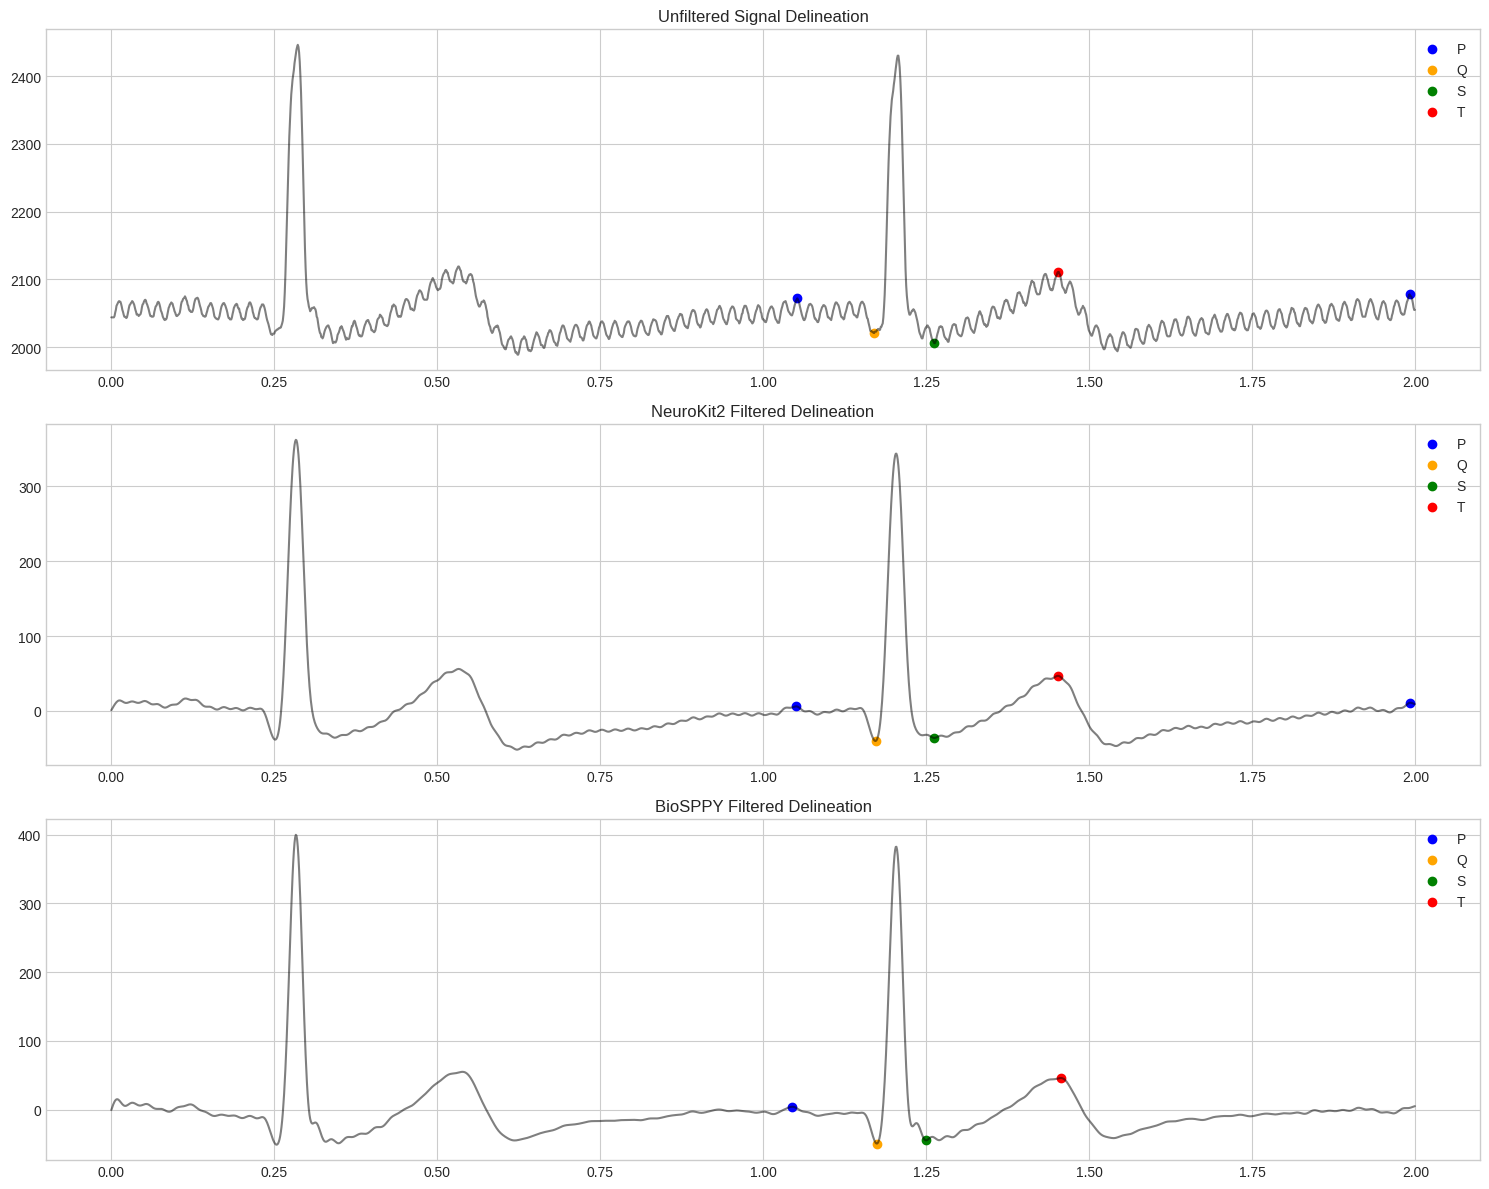

In [55]:
# Finally, run the delineation on the filtered signal from BioSPPY.

# Define a 2-second window for the comparison plot
window = int(2 * SAMPLING_RATE) 
time_axis_win = np.arange(window) / SAMPLING_RATE

plt.figure(figsize=(15, 12))
wave_colors = {'P': 'blue', 'Q': 'orange', 'S': 'green', 'T': 'red'}

# --- Subplot 1: Unfiltered ---
plt.subplot(3, 1, 1)
plt.plot(time_axis_win, signal[:window], color='black', alpha=0.5)
for wave, color in wave_colors.items():
    p_idxs = [x for x in waves_unfiltered[f"ECG_{wave}_Peaks"] if not np.isnan(x) and x < window]
    plt.scatter(np.array(p_idxs)/SAMPLING_RATE, signal[np.array(p_idxs, dtype=int)], color=color, label=wave)
plt.title("Unfiltered Signal Delineation")
plt.legend(loc='upper right')

# --- Subplot 2: NeuroKit2 Filtered (0.5-30Hz) ---
plt.subplot(3, 1, 2)
plt.plot(time_axis_win, filtered_nk[:window], color='black', alpha=0.5)
for wave, color in wave_colors.items():
    p_idxs = [x for x in waves_filtered_nk[f"ECG_{wave}_Peaks"] if not np.isnan(x) and x < window]
    plt.scatter(np.array(p_idxs)/SAMPLING_RATE, filtered_nk[np.array(p_idxs, dtype=int)], color=color, label=wave)
plt.title("NeuroKit2 Filtered Delineation")
plt.legend(loc='upper right')

# --- Subplot 3: BioSPPY Filtered ---
plt.subplot(3, 1, 3)
plt.plot(time_axis_win, out['filtered'][:window], color='black', alpha=0.5)
for wave, color in wave_colors.items():
    p_idxs = [x for x in waves_filtered_biosppy[f"ECG_{wave}_Peaks"] if not np.isnan(x) and x < window]
    plt.scatter(np.array(p_idxs)/SAMPLING_RATE, out['filtered'][np.array(p_idxs, dtype=int)], color=color, label=wave)
plt.title("BioSPPY Filtered Delineation")
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
# TODO Which one works the best?

print("The BioSPPY Filtered or NeuroKit2 Filtered signals typically work best." \
"\nFiltering removes 'baseline wander' (the slow waving of the signal) and high-frequency "
"'fuzz' \n(muscle noise). This makes the smaller P and T waves have a much more consistent shape, " \
"\nallowing the delineation algorithm to spot the peaks more reliably and accurately compared to the \n" \
"noisy unfiltered signal.")

The BioSPPY Filtered or NeuroKit2 Filtered signals typically work best.
Filtering removes 'baseline wander' (the slow waving of the signal) and high-frequency 'fuzz' 
(muscle noise). This makes the smaller P and T waves have a much more consistent shape, 
allowing the delineation algorithm to 'spot' the peaks more reliably and accurately compared to the 
noisy unfiltered signal.


### The BioSPPY Filtered or NeuroKit2 Filtered signals typically work best. Filtering removes 'baseline wander' (the slow waving of the signal) and high-frequency 'fuzz' (muscle noise). This makes the smaller P and T waves have a much more consistent shape, allowing the delineation algorithm to spot the peaks more reliably and accurately compared to the noisy unfiltered signal.

In [ ]:
#
# Great job!!
#
#  , ; ,   .-'"""'-.   , ; ,
#  \\|/  .'         '.  \|//
#   \-;-/   ()   ()   \-;-/
#   // ;               ; \\
#  //__; :.         .; ;__\\
# `-----\'.'-.....-'.'/-----'
#        '.'.-.-,_.'.'
#jgs       '(  (..-'
#            '-'
#